In [2]:
import numpy as np 
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline
warnings.filterwarnings('ignore')


In [3]:
raw = pd.read_csv('data/aapl.csv',index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2011-10-10 to 2021-10-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [17]:
data = (pd.DataFrame(raw['Close']).dropna())

data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)
data['Lag4'] = data['Close'].shift(4)
data['Min1Trend'] = np.where(data['Lag1'] - data['Lag2']>0,1,-1)
data['Min2Trend'] = np.where(data['Lag2'] - data['Lag3']>0,1,-1)
data['Min3Trend'] = np.where(data['Lag3'] - data['Lag4']>0,1,-1)
data['Trend_3_day'] = np.where(data['Min1Trend']+data['Min2Trend']+data['Min3Trend']>0,1,-1)

traindata = data[['Close','Lag1','Trend_3_day']]
traindata.dropna(inplace=True)
traindata.head(10)

#traindata.plot(y='Close', figsize=(10,6))

traindata.to_csv('data/aapl_features.csv')



(array([18567., 18628., 18687., 18748., 18809., 18871.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

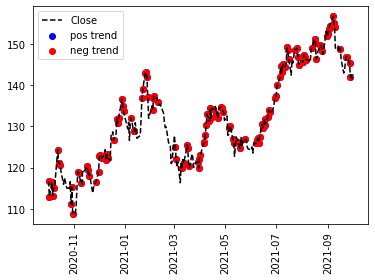

In [7]:
start_date = '2020-10-01'
end_date = '2021-10-01'
if not 'Date' in traindata.columns:
    traindata.insert(loc=0,column='Date',value=pd.to_datetime(traindata.index))

plt.plot('Date','Close','k--',data=(traindata.loc[pd.to_datetime(traindata.Date).between(start_date,end_date)]))

plt.scatter('Date','Close',color='b',label='pos trend',data=(
    traindata.loc[traindata.Trend_3_day == 1 & pd.to_datetime(traindata.Date).between(start_date,end_date)]))

#plt.scatter('Date','Close',color='r',label='neg trend',data=(
#    traindata.loc[traindata.Trend_3_day == -1 & pd.to_datetime(traindata.Date).between(start_date,end_date)]))

plt.legend()
plt.xticks(rotation=90)


In [6]:
features = ['Lag1','Trend_3_day']
target= 'Close'
data.info

X_train, X_test = traindata.loc[:'2016-10-10',features] , traindata.loc['2016-10-10':,features]
Y_train, Y_test = traindata.loc[:'2016-10-10',target],traindata.loc['2016-10-10':,target]
#plt.plot(X_train,label='training set')
#plt.plot(X_test,label='Test set',color='orange')
#plt.legend()


In [8]:
regr = linear_model.LinearRegression(fit_intercept=False)

In [9]:
regr.fit(X_train,Y_train)

LinearRegression(fit_intercept=False)

In [12]:
Y_pred = regr.predict(X_test)

In [15]:
print('RMSE: {0:.2f}',format(np.sqrt(mean_squared_error(Y_test,Y_pred))))
print('Variance score: {0:.2f}',format(r2_score(Y_test,Y_pred)))

RMSE: {0:.2f} 1.5373596123754525
Variance score: {0:.2f} 0.9982816542420694


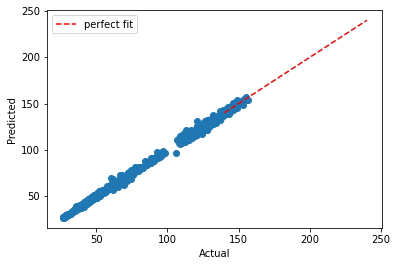

In [16]:
plt.scatter(Y_test,Y_pred)
plt.plot([140,240],[140,240],'r--',label='perfect fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()